In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brighteyes_ism.dataio.mcs as mcs
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.analysis.Graph_lib as gr

from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans

import os

In [2]:
def point_cloud_from_img(dset):
    shape = dset.shape

    N = dset.size

    indices = np.array(np.unravel_index(range(N), shape)).T

    values = dset.flatten()

    point_cloud_matrix = np.column_stack((indices, values))

    return point_cloud_matrix

In [3]:
path = r'\\iitfsvge101.iit.local\mms\Data MMS server\STED-ISM\SetupDiagnostics\calibrations\argolight\stairs\new_offset_5V'

for file in sorted( os.listdir(path) ):
    if file.endswith('.h5'):
        print(file)
        break

fullpath = os.path.join(path, file)
        
data, meta = mcs.load(fullpath)
data = np.sum(data, axis = (0,4,5) )

data = tool.CropEdge(data, npx = 50, edges = 'lrud', order = 'zxy')

dset = data[:, 200:-200, 50:-50]

data-17-10-2023-12-31-54.h5


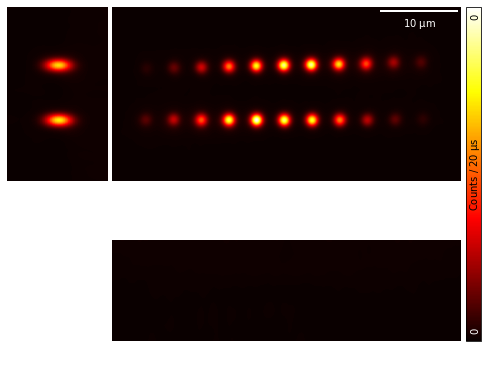

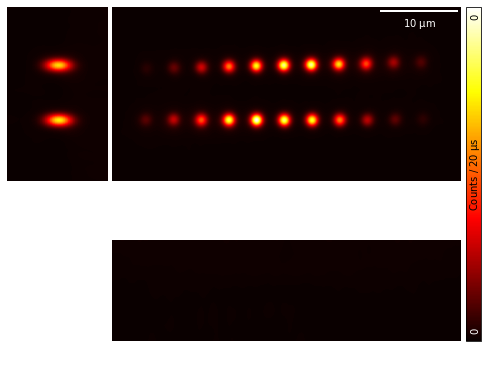

In [13]:
figsize = (7,6)
fig = gr.ShowStack(dset, meta.dx, meta.dz/2, clabel = meta.pxdwelltime, figsize = figsize)

In [5]:
dset = gaussian(dset, sigma = 5)
dset /= dset.max()

In [6]:
point_cloud_matrix = point_cloud_from_img(dset)

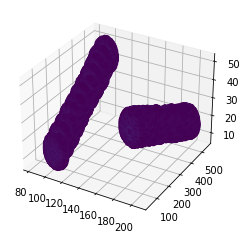

In [7]:
thresh = threshold_otsu(dset)

cloud = point_cloud_matrix[ point_cloud_matrix[:, -1] > thresh ]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cloud[:,1], cloud[:,2], cloud[:,0], c = cloud[:,3])

In [8]:
model = KMeans(n_clusters = 22, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(cloud)

cm = model.cluster_centers_

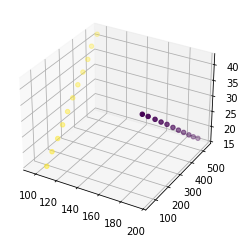

In [9]:
ym = cm[:, 1].mean()
cm_classes = cm[:, 1] < ym

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cm[:, 1], cm[:, 2], cm[:, 0], c=cm_classes)

In [10]:
z_a = np.sort( cm[cm_classes==0,0] ) * meta.dz / meta.calib_z # Volt

z_b = np.sort( cm[cm_classes==1,0] ) * meta.dz / meta.calib_z # Volt

x = np.arange(len(z_a))

z_calib = 4.75 um/V


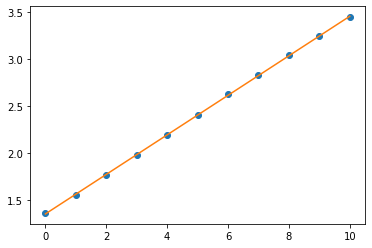

In [11]:
poly = np.polyfit(x, z_a, 1)

fit = np.poly1d(poly)

z_calib = 1 / poly[0] # um/Volt

print( f'z_calib = {z_calib:.2f} um/V' )

plt.figure()
plt.plot( z_a, 'o' )
plt.plot( fit(x), '-' )

z_calib = 4.74 um/V


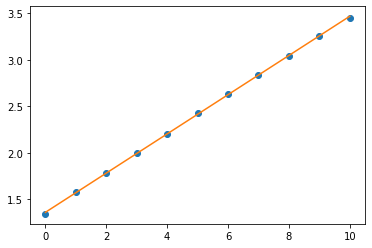

In [12]:
poly = np.polyfit(x, z_b, 1)

fit = np.poly1d(poly)

z_calib = 1 / poly[0] # um/Volt

print( f'z_calib = {z_calib:.2f} um/V' )

plt.figure()
plt.plot( z_b, 'o' )
plt.plot( fit(x), '-' )